Parts of this assignment will be **automatically graded**. Please take note of the following:
- Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All).
- You can add additional cells, but it is not recommended to (re)move cells. Cells required for autograding cannot be moved and cells containing tests cannot be edited.
- You are allowed to use a service such as [Google Colaboratory](https://colab.research.google.com/) to work together. However, you **cannot** hand in the notebook that was hosted on Google Colaboratory, but you need to copy your answers into the original notebook and verify that it runs succesfully offline. This is because Google Colaboratory destroys the metadata required for grading.
- Name your notebook **exactly** `{TA_name}_{student1_id}_{student2_id}_lab{i}.ipynb`, for example `wouter_12345_67890_lab1.ipynb` (or tim|elise|david|qi, depending on your TA), **otherwise your submission will be skipped by our regex and you will get 0 points** (but no penalty as we cannot parse your student ids ;)).

Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE", as well as your names below:

In [1]:
NAMES = "Bobbie van Gorp and Marvin Lau"

---

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import sys
from tqdm import tqdm as _tqdm

def tqdm(*args, **kwargs):
    return _tqdm(*args, **kwargs, mininterval=1)  # Safety, do not overflow buffer

%matplotlib inline

assert sys.version_info[:3] >= (3, 6, 0), "Make sure you have Python 3.6 installed!"

---
## 1. Policy Evaluation (1 point)

In this exercise we will evaluate a policy, e.g. find the value function for a policy. The problem we consider is the gridworld from Example 4.1 in the book. The environment is implemented as `GridworldEnv`, which is a subclass of the `Env` class from [OpenAI Gym](https://github.com/openai/gym). This means that we can interact with the environment. We can look at the documentation to see how we can interact with the environment.

In [3]:
from gridworld import GridworldEnv
env = GridworldEnv()
# Lets see what this is
?env

In [4]:
# To have a quick look into the code
??env

Now we want to evaluate a policy by using Dynamic Programming. For more information, see the [Intro to RL](https://drive.google.com/open?id=1opPSz5AZ_kVa1uWOdOiveNiBFiEOHjkG) book, section 4.1. This algorithm requires knowledge of the problem dynamics in the form of the transition probabilities $p(s',r|s,a)$. In general these are not available, but for our gridworld we know the dynamics and these can be accessed as `env.P`.

In [5]:
# Take a moment to figure out what P represents. 
# Note that this is a deterministic environment. 
# What would a stochastic environment look like?
env.P

{0: {0: [(1.0, 0, 0.0, True)],
  1: [(1.0, 0, 0.0, True)],
  2: [(1.0, 0, 0.0, True)],
  3: [(1.0, 0, 0.0, True)]},
 1: {0: [(1.0, 1, -1.0, False)],
  1: [(1.0, 2, -1.0, False)],
  2: [(1.0, 5, -1.0, False)],
  3: [(1.0, 0, -1.0, True)]},
 2: {0: [(1.0, 2, -1.0, False)],
  1: [(1.0, 3, -1.0, False)],
  2: [(1.0, 6, -1.0, False)],
  3: [(1.0, 1, -1.0, False)]},
 3: {0: [(1.0, 3, -1.0, False)],
  1: [(1.0, 3, -1.0, False)],
  2: [(1.0, 7, -1.0, False)],
  3: [(1.0, 2, -1.0, False)]},
 4: {0: [(1.0, 0, -1.0, True)],
  1: [(1.0, 5, -1.0, False)],
  2: [(1.0, 8, -1.0, False)],
  3: [(1.0, 4, -1.0, False)]},
 5: {0: [(1.0, 1, -1.0, False)],
  1: [(1.0, 6, -1.0, False)],
  2: [(1.0, 9, -1.0, False)],
  3: [(1.0, 4, -1.0, False)]},
 6: {0: [(1.0, 2, -1.0, False)],
  1: [(1.0, 7, -1.0, False)],
  2: [(1.0, 10, -1.0, False)],
  3: [(1.0, 5, -1.0, False)]},
 7: {0: [(1.0, 3, -1.0, False)],
  1: [(1.0, 7, -1.0, False)],
  2: [(1.0, 11, -1.0, False)],
  3: [(1.0, 6, -1.0, False)]},
 8: {0: [(1.0, 4

In [6]:
def policy_eval(policy, env, discount_factor=1.0, theta=0.00001):
    """
    Evaluate a policy given an environment and a full description of the environment's dynamics.
    
    Args:
        policy: [S, A] shaped matrix representing the policy.
        env: OpenAI env. env.P represents the transition probabilities of the environment.
            env.P[s][a] is a list of transition tuples (prob, next_state, reward, done).
            env.nS is a number of states in the environment. 
            env.nA is a number of actions in the environment.
        theta: We stop evaluation once our value function change is less than theta for all states.
        discount_factor: Gamma discount factor.
    
    Returns:
        Vector of length env.nS representing the value function.
    """
    # Start with a random (all 0) value function
    V = np.zeros(env.nS)
    while True:
        delta = 0
        for s in range(env.nS):
            v_value = V[s]
            sa_probs = policy[s]
            new_v_value = 0
            
            for a in range(env.nA):
                action_prob  = sa_probs[a]
                trans_prob,next_state,reward,done = env.P[s][a][0]
                new_v_value += action_prob * trans_prob * (reward + discount_factor * V[next_state])
            diff = np.abs(v_value - new_v_value)
            V[s] = new_v_value
            delta = max(delta,diff)
            
        if delta < theta:
            break
    return np.array(V)

In [7]:
# Let's run your code, does it make sense?
random_policy = np.ones([env.nS, env.nA]) / env.nA
V = policy_eval(random_policy, env)
V

array([  0.        , -13.99993529, -19.99990698, -21.99989761,
       -13.99993529, -17.9999206 , -19.99991379, -19.99991477,
       -19.99990698, -19.99991379, -17.99992725, -13.99994569,
       -21.99989761, -19.99991477, -13.99994569,   0.        ])

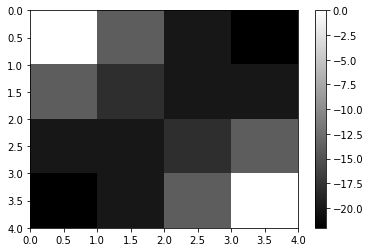

In [8]:
def plot_gridworld_value(V):
    plt.figure()
    c = plt.pcolormesh(V, cmap='gray')
    plt.colorbar(c)
    plt.gca().invert_yaxis()  # In the array, first row = 0 is on top

# Making a plot always helps
plot_gridworld_value(V.reshape(env.shape))

In [9]:
# Test: When you hand in the nodebook we will check that the value function is (approximately) what we expected
# but we need to make sure it is at least of the correct shape
v = policy_eval(random_policy, env)
assert v.shape == (env.nS)

---
## 2. Policy Iteration (2 points)
Using the policy evaluation algorithm we can implement policy iteration to find a good policy for this problem. Note that we do not need to use a discount_factor for episodic tasks but make sure your implementation can handle this correctly!

In [10]:
def policy_improvement(env, discount_factor=1.0):
    """
    Policy Improvement Algorithm. Iteratively evaluates and improves a policy
    until an optimal policy is found.
    
    Args:
        env: The OpenAI envrionment.
        policy_eval_fn: Policy Evaluation function that takes 3 arguments:
            policy, env, discount_factor.
        discount_factor: gamma discount factor.
        
    Returns:
        A tuple (policy, V). 
        policy is the optimal policy, a matrix of shape [S, A] where each state s
        contains a valid probability distribution over actions.
        V is the value function for the optimal policy.
        
    """
    # Start with a random policy
    policy = np.ones([env.nS, env.nA]) / env.nA
    
    while True:
        
        V = policy_eval(policy, env, discount_factor)
        policy_stable = True

        for s in range(env.nS):
            old_action = np.random.choice(env.nA,1,p = policy[s])
            best_action = -1
            highest_value = -10000
            
            for a in range(env.nA):
                trans_prob,next_state,reward,done = env.P[s][a][0]
                value_action = trans_prob * (reward + discount_factor * V[next_state])
                if value_action > highest_value:
                    best_action = a
                    highest_value = value_action
                
            sa_prob = np.zeros(env.nA)
            sa_prob[best_action] = 1
            policy[s] = sa_prob    
            
            if old_action != best_action:
                policy_stable = False

        if policy_stable:
            break         
    
    return policy, V

Policy Probability Distribution:
[[1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]]

Reshaped Grid Policy (0=up, 1=right, 2=down, 3=left):
[[0 3 3 2]
 [0 0 0 2]
 [0 0 1 2]
 [0 1 1 0]]
^<<v
^^^v
^^>v
^>>^

Value Function:
[ 0. -1. -2. -3. -1. -2. -3. -2. -2. -3. -2. -1. -3. -2. -1.  0.]

Reshaped Grid Value Function:
[[ 0. -1. -2. -3.]
 [-1. -2. -3. -2.]
 [-2. -3. -2. -1.]
 [-3. -2. -1.  0.]]



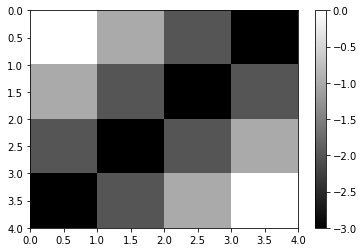

In [11]:
# Let's see what it does
policy, v = policy_improvement(env)
print("Policy Probability Distribution:")
print(policy)
print("")

def print_grid_policy(policy, symbols=["^", ">", "v", "<"]):
    symbols = np.array(symbols)
    for row in policy:
        print("".join(symbols[row]))

print("Reshaped Grid Policy (0=up, 1=right, 2=down, 3=left):")
print(np.reshape(np.argmax(policy, axis=1), env.shape))
print_grid_policy(np.reshape(np.argmax(policy, axis=1), env.shape))
print("")

print("Value Function:")
print(v)
print("")

print("Reshaped Grid Value Function:")
print(v.reshape(env.shape))
print("")

plot_gridworld_value(v.reshape(env.shape))

In [12]:
# This is not an empty cell. It is needed for grading.

---
## 3. Value Iteration (3 points)
Now implement the value iteration algorithm.

In [13]:
def value_iteration(env, theta=0.0001, discount_factor=1.0):
    """
    Value Iteration Algorithm.
    
    Args:
        env: OpenAI env. env.P represents the transition probabilities of the environment.
            env.P[s][a] is a list of transition tuples (prob, next_state, reward, done).
            env.nS is a number of states in the environment. 
            env.nA is a number of actions in the environment.
        theta: We stop evaluation once our value function change is less than theta for all states.
        discount_factor: Gamma discount factor.
        
    Returns:
        A tuple (policy, V) of the optimal policy and the optimal value function.        
    """
    

    V = np.zeros(env.nS)
    policy = np.zeros([env.nS, env.nA])

    while True:
        delta = 0
        
        for s in range(env.nS):
            v_value = V[s]
            values = []
            for a in range(env.nA):
                trans_prob,next_state,reward,done = env.P[s][a][0]
                action_value = trans_prob * (reward + discount_factor * V[next_state])
                values.append(action_value)
            
            new_v_value = max(values)
            diff = np.abs(v_value - new_v_value)
            V[s] = new_v_value
            delta = max(delta,diff)

        if delta < theta:
            break
            
    for s in range(env.nS):
        v_value = V[s]
        values = []
        for a in range(env.nA):
            trans_prob,next_state,reward,done = env.P[s][a][0]
            action_value = trans_prob * (reward + discount_factor * V[next_state])
            values.append(action_value)
        action = np.argmax(values)
        policy[s,action] = 1
    
    return policy, V

In [14]:
# Oh let's test again
# Let's see what it does
policy, v = value_iteration(env)
print("Policy Probability Distribution:")
print(policy)
print("")

print("Reshaped Grid Policy (0=up, 1=right, 2=down, 3=left):")
print(np.reshape(np.argmax(policy, axis=1), env.shape))
print_grid_policy(np.reshape(np.argmax(policy, axis=1), env.shape))
print("")

print("Value Function:")
print(v)
print("")

print("Reshaped Grid Value Function:")
print(v.reshape(env.shape))
print("")


Policy Probability Distribution:
[[1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]]

Reshaped Grid Policy (0=up, 1=right, 2=down, 3=left):
[[0 3 3 2]
 [0 0 0 2]
 [0 0 1 2]
 [0 1 1 0]]
^<<v
^^^v
^^>v
^>>^

Value Function:
[ 0. -1. -2. -3. -1. -2. -3. -2. -2. -3. -2. -1. -3. -2. -1.  0.]

Reshaped Grid Value Function:
[[ 0. -1. -2. -3.]
 [-1. -2. -3. -2.]
 [-2. -3. -2. -1.]
 [-3. -2. -1.  0.]]



What is the difference between value iteration and policy iteration? Which algorithm is most efficient (e.g. needs to perform the least *backup* operations)? Please answer *concisely* in the cell below.

Both value iteration and policy iteration are iterative algorithms in which the policy and the value functions are updated alternately. In policy iteration, these steps are called policy improvement and policy evaluation, where the value function is updated until convergence in every iteration. In value iteration, these steps are combined into a single update rule. This is possible because the value function is not updated to convergence in every iteration, but is this process is truncated after one update of each state value. Both are generalised policy iteration examples, but since value iteration combines the truncated policy evaluation and policy improvement in a single update rule, it needs less backup operations than the policy iteration method. 

## 4. Monte Carlo Prediction (7 points)
What is the difference between Dynamic Programming and Monte Carlo? When would you use the one or the other algorithm?

In Dynamic Programming (DP) a perfect model of the environment given as a Markov decision process (MDP) is required. For example, we have to know the MDP dynamics such as the transition probabilities in order to make use of Bellman equations and compute the optimal V or Q functions. This also means that it can be expensive to compute. 
Monte Carlo methods do not require a perfect model of the enviroment, only experience is needed. We can generate/simulate episodes to gather data (our experience) and get the expected return in order to estimate and learn the value function. The tasks to be solved with Monte Carlo methods need to be epiosodic. With a single Monte Carlo simulation we can only take a look a one possible future and not all possible future states as in DP. The estimate of the value of a single state is independent of the estimate of the value of other states when using Monte Carlo methods. This makes estimating the value of a single state using Monte Carlo methods attractive, because it is computionally much less expensive than the full DP approach, especially when there is a large number of states. 


For the Monte Carlo Prediction we will look at the Blackjack game (Example 5.1 from the book), for which the `BlackjackEnv` is implemented in `blackjack.py`. Note that compared to the gridworld, the state is no longer a single integer, which is why we use a dictionary to represent the value function instead of a numpy array. By using `defaultdict`, each state gets a default value of 0.

In [15]:
from blackjack import BlackjackEnv
env = BlackjackEnv()

For the Monte Carlo algorithm, we need to *interact* with the environment. This means that we start an episode by using `env.reset` and send the environment actions via `env.step` to observe the reward and next observation (state).

In [16]:
# So let's have a look at what we can do in general with an environment...
import gym
?gym.Env

In [17]:
# We can also look at the documentation/implementation of a method
?env.step

In [18]:
??BlackjackEnv

A very simple policy for Blackjack is to *stick* if we have 20 or 21 points and *hit* otherwise. We want to know how good this policy is. This policy is *deterministic* and therefore a function that maps an observation to a single action. Technically, we can implement this as a dictionary or as a function, where we use the latter. To get started, let's implement this simple policy for BlackJack.

In [19]:
def simple_policy(observation):
    """
    A policy that sticks if the player score is >= 20 and hits otherwise.
    """
    player_sum, dealer_card, usable_ace = observation
    if player_sum < 20:
        a = 1
    else:
        a = 0
    return a

In [20]:
s = env.reset()
print(s)
a = simple_policy(s)
print(env.step(a))

(16, 5, False)
((25, 5, False), -1, True, {})


Now implement either the MC prediction algorithm (either first visit or every visit). Hint: you can use `for i in tqdm(range(num_episodes))` to show a progress bar.

In [21]:
from collections import defaultdict

def mc_prediction(policy, env, num_episodes, discount_factor=1.0):
    """
    Monte Carlo prediction algorithm. Calculates the value function
    for a given policy using sampling.
    
    Args:
        policy: A function that maps an observation to action probabilities.
        env: OpenAI gym environment.
        num_episodes: Number of episodes to sample.
        discount_factor: Gamma discount factor.
    
    Returns:
        A dictionary that maps from state -> value.
        The state is a tuple and the value is a float.
    """

    # Keeps track of sum and count of returns for each state
    # to calculate an average. We could use an array to save all
    # returns (like in the book) but that's memory inefficient.
    returns_sum = defaultdict(float)
    returns_count = defaultdict(float)
    
    # The final value function
    V = defaultdict(float)
    
    for i in tqdm(range(num_episodes)):
        
        initial_s = env.reset()
        a = policy(initial_s)
        observation,reward,done,info = env.step(a)
        
        episode = [(initial_s,reward)]
        while not done:
            last_observation = observation
            a = policy(observation)
            observation,reward,done,info = env.step(a)
            episode.append((last_observation,reward))
            
        G = 0
        for i in range(len(episode)-1,-1,-1):
            s,reward = episode[i]
            G = (discount_factor * G) + reward 
            
            returns_sum[s] += G
            returns_count[s] += 1
            
            avg_s = returns_sum[s] / returns_count[s]
            V[s] = avg_s
    
    return V

In [22]:
V = mc_prediction(simple_policy, env, num_episodes=1000)
print(V)

100%|██████████| 1000/1000 [00:00<00:00, 18248.32it/s]

defaultdict(<class 'float'>, {(19, 1, False): -0.9166666666666666, (21, 8, True): 0.8571428571428571, (17, 1, False): -0.6666666666666666, (21, 5, True): 0.8, (18, 5, True): 0.0, (15, 5, True): 0.0, (17, 4, False): -0.6923076923076923, (16, 4, False): -0.3, (18, 4, True): -1.0, (13, 4, False): -0.8, (12, 4, False): -0.5, (19, 4, True): -1.0, (18, 4, False): -0.75, (17, 3, False): -0.8888888888888888, (20, 3, False): 0.6190476190476191, (20, 2, False): 0.8235294117647058, (21, 10, False): 0.8709677419354839, (19, 10, False): -0.8723404255319149, (18, 6, False): -0.7333333333333333, (17, 10, False): -0.7073170731707317, (14, 5, False): -0.7142857142857143, (14, 5, True): -1.0, (14, 10, False): -0.8113207547169812, (14, 10, True): -0.5555555555555556, (16, 7, False): -0.8333333333333334, (17, 7, False): -1.0, (14, 8, False): -0.8, (15, 8, True): -1.0, (14, 1, False): -1.0, (14, 2, False): -0.6666666666666666, (17, 2, True): -1.0, (19, 8, False): -0.8181818181818182, (19, 8, True): -1.0, (

Now make *4 plots* like Figure 5.1 in the book. You can either make 3D plots or heatmaps. Make sure that your results look similar to the results in the book. Give your plots appropriate titles, axis labels, etc.

In [23]:
%%time
# Let's run your code one time
V_10k = mc_prediction(simple_policy, env, num_episodes=10000)
V_500k = mc_prediction(simple_policy, env, num_episodes=500000)

100%|██████████| 500000/500000 [00:18<00:00, 26461.28it/s]

CPU times: user 19.2 s, sys: 10.2 ms, total: 19.3 s
Wall time: 19.2 s


Populating the interactive namespace from numpy and matplotlib


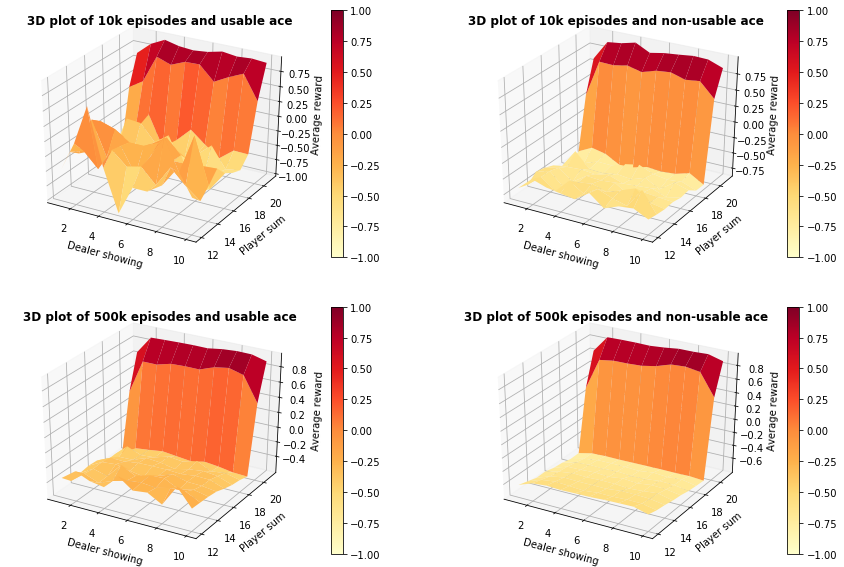

In [24]:
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt
%pylab inline
plt.rcParams["figure.figsize"] = [15,10]
fig = plt.figure()

titles = ["10k episodes and usable ace","10k episodes and non-usable ace",
         "500k episodes and usable ace","500k episodes and non-usable ace"]

x,y = np.meshgrid(np.arange(1,11), np.arange(12,22))
plot_number = 0

for data in [V_10k,V_500k]:
    sorted_ace = sorted(data.items(), key=lambda v: v[0][2])
    if len(sorted_ace) == 200:
        no_ace = sorted_ace[:100]
        ace = sorted_ace[100:]
    
    for type_ace in [ace,no_ace]:
        z = np.zeros((10,10))
        for step in type_ace:
            state, reward = step
            player_sum,dealer,usable_ace = state
            #z[player_sum-12,dealer-1] = reward
            z[player_sum-12,dealer-1] = reward
            
        plot_number += 1
        ax = plt.subplot(int(str(22) + str(plot_number)),projection='3d')
        ax.set_title('3D plot of ' + titles[plot_number-1],fontsize=12,fontweight = "bold");
        ax.set_ylabel('Player sum')
        ax.set_xlabel('Dealer showing')
        ax.set_zlabel('Average reward')
        
        surf = ax.plot_surface(x, y, z, rstride=1, cstride=1,cmap="YlOrRd",  vmin=-1.0, vmax=1.0)
        fig.colorbar(surf)
plt.show()

## 5. Monte Carlo control with $\epsilon$-greedy policy (5 points)
Now we have a method to evaluate state-values given a policy. Take a moment to think whether we can use the value function to find a better policy? Assuming we do not know the dynamics of the environment, why is this not possible?

We want a policy that selects _actions_ with maximum value, e.g. is _greedy_ with respect to the _action-value_ (or Q-value) function $Q(s,a)$. We need to keep exploring, so with probability $\epsilon$ we will take a random action. First, lets implement a function `make_epsilon_greedy_policy` that takes the Q-value function and returns an $\epsilon$-greedy policy. The policy itself is a function that returns an action.

In [25]:
def make_epsilon_greedy_policy(Q, epsilon, nA):
    """
    Creates an epsilon-greedy policy based on a given Q-function and epsilon.
    
    Args:
        Q: A dictionary that maps from state -> action-values.
            Each value is a numpy array of length nA (see below)
        epsilon: The probability to select a random action . float between 0 and 1.
        nA: Number of actions in the environment.
    
    Returns:
        A function that takes the observation as an argument and returns
        an action according to the epsilon-greedy policy.
    
    """
    def policy_fn(observation):
        epsilon_share = epsilon / nA
        sa = Q[observation]
        max_value_index = np.argmax(sa)
        action_p = []

        for i in range(nA):
            if i != max_value_index:
                action_p.append(epsilon_share)
            else:
                action_p.append(1.0-epsilon + epsilon_share)
                
        a = np.random.choice(nA,1,p=action_p)[0]
        
        return a

    return policy_fn

In [26]:
def mc_control_epsilon_greedy(env, num_episodes, discount_factor=1.0, epsilon=0.1):
    """
    Monte Carlo Control using Epsilon-Greedy policies.
    Finds an optimal epsilon-greedy policy.
    
    Args:
        env: OpenAI gym environment.
        num_episodes: Number of episodes to sample.
        discount_factor: Gamma discount factor.
        epsilon: Chance the sample a random action. Float betwen 0 and 1.
    
    Returns:
        A tuple (Q, policy).
        Q is a dictionary mapping state -> action values.
        policy is a function that takes an observation as an argument and returns
        action probabilities
    """
    
    # Again, keep track of counts for efficiency
    # returns_sum, returns_count and Q are 
    # nested dictionaries that map state -> (action -> action-value).
    # We could also use tuples (s, a) as keys in a 1d dictionary, but this
    # way Q is in the format that works with make_epsilon_greedy_policy
    
    returns_sum = defaultdict(lambda: np.zeros(env.action_space.n))
    returns_count = defaultdict(lambda: np.zeros(env.action_space.n, dtype=int))
    
    # The final action-value function.
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    
    # The policy we're following
    policy = make_epsilon_greedy_policy(Q, epsilon, env.action_space.n)
    
    for i in tqdm(range(num_episodes)):
        initial_s = env.reset()
        a = policy(initial_s)
        observation,reward,done,info = env.step(a)
        
        episode = [(initial_s,a,reward)]
        while not done:
            last_observation = observation
            a = policy(observation)
            observation,reward,done,info = env.step(a)
            episode.append((last_observation,a,reward))
            
        G = 0
        for i in range(len(episode)-1,-1,-1):
            s,a,reward = episode[i]
            G = (discount_factor * G) + reward 
            
            returns_sum[s][a] += G
            returns_count[s][a] += 1
            
            avg_sa = returns_sum[s][a] / returns_count[s][a]
            Q[s][a] = avg_sa
    
    return Q, policy

# Test it quickly
Q, policy = mc_control_epsilon_greedy(env, num_episodes=10000, epsilon=0.1)

100%|██████████| 10000/10000 [00:00<00:00, 11956.90it/s]


In [27]:
%%time
Q, policy = mc_control_epsilon_greedy(env, num_episodes=500000, epsilon=0.1)

100%|██████████| 500000/500000 [00:43<00:00, 11552.20it/s]

CPU times: user 43.3 s, sys: 7.94 ms, total: 43.3 s
Wall time: 43.3 s


How can you obtain the (V-)value function from the Q-value function? Plot the (V-)value function that is the result of 500K iterations. Additionally, visualize the greedy policy similar to Figure 5.2 in the book. Use a white square for hitting, black for sticking.

$V^*(s) = max_a q_{\pi} (s,a)$

/home/bobbiegorp/anaconda3/envs/rl2019/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['step']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


Populating the interactive namespace from numpy and matplotlib


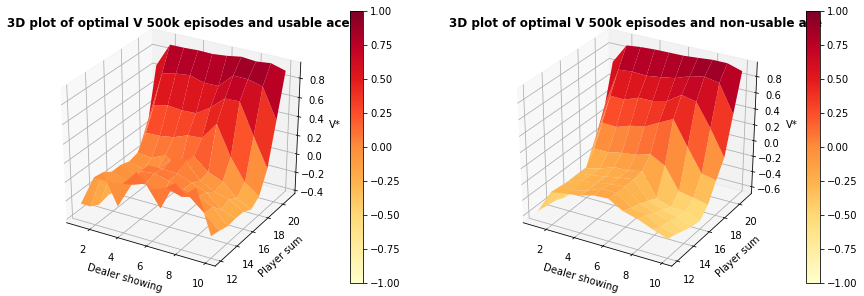

In [28]:
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt
from matplotlib import colors
%pylab inline
plt.rcParams["figure.figsize"] = [15,5]
fig = plt.figure()

titles = ["500k episodes and usable ace","500k episodes and non-usable ace"]

x,y = np.meshgrid(np.arange(1,11), np.arange(12,22))
plot_number = 0

cmap = colors.ListedColormap(['black', 'white'])
bounds = [0.0,0.5,1.0]
norm = colors.BoundaryNorm(bounds, cmap.N)

for plot_number,ace in enumerate([True,False]):
    z = np.zeros((10,10))
    z2 = np.zeros((10,10))
    for dealer in range(11):
        for player_sum in range(12,22):
            #V*
            s = (player_sum,dealer,ace)
            v = max(Q[s])
            z[player_sum-12,dealer-1] = v
            
            #Actions
            z2[player_sum-12,dealer-1] = np.argmax(Q[s])
    z2 = np.flip(z2, 0)
    
    ax = plt.subplot(int(str(12) + str(plot_number+1)),projection='3d')
    ax.set_title('3D plot of optimal V ' + titles[plot_number],fontsize=12,fontweight = "bold");
    ax.set_ylabel('Player sum')
    ax.set_xlabel('Dealer showing')
    ax.set_zlabel('V*')

    surf = ax.plot_surface(x, y, z, rstride=1, cstride=1,cmap="YlOrRd",  vmin=-1.0, vmax=1.0)
    fig.colorbar(surf)
    
plt.show()



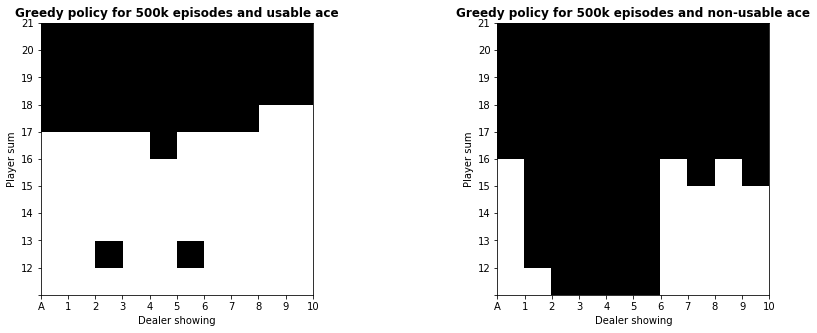

In [29]:
from matplotlib import colors

cmap = colors.ListedColormap(['black', 'white'])
bounds = [0.0,0.5,1]
norm = colors.BoundaryNorm(bounds, cmap.N)

titles = ["500k episodes and usable ace","500k episodes and non-usable ace"]

x,y = np.meshgrid(np.arange(1,11), np.arange(12,22))
plot_number = 0

for plot_number,ace in enumerate([True,False]):
    z2 = np.zeros((10,10))
    for dealer in range(11):
        for player_sum in range(12,22):
            #Actions
            s = (player_sum,dealer,ace)
            z2[player_sum-12,dealer-1] = np.argmax(Q[s])
            
    z2 = np.flip(z2, 0)
    
    ax = plt.subplot(int(str(12) + str(plot_number+1)))
    ax.set_title('Greedy policy for ' + titles[plot_number],fontsize=12,fontweight = "bold");
    ax.set_ylabel('Player sum')
    ax.set_xlabel('Dealer showing')
    ax.imshow(z2, cmap=cmap, norm=norm)

    ax.grid(which='minor', axis='both', linestyle='-', color='k', linewidth=2)
    ax.set_xticks(np.arange(-.5, 10, 1));
    ax.set_xticklabels(["A","1","2","3","4","5","6","7","8","9","10"])
    ax.set_yticks(np.arange(-.5, 10, 1));
    ax.set_yticklabels(["21","20","19","18","17","16","15","14","13","12"])

plt.show()